In [1]:
from scipy.io import wavfile

(source_fs, source_data) = wavfile.read('./data/2nd_experiment/source.wav')
(target_fs, target_data) = wavfile.read('./data/2nd_experiment/ml.wav')


In [2]:
import pandas as pd

In [3]:
source_df = pd.DataFrame(source_data, columns=['L', 'R'])['L']
target_df = pd.DataFrame(target_data, columns=['L', 'R'])['L']

(
    source_df.max(),
    target_df.max()
)

(28421, 23898)

In [4]:
MAX_VALUE = 2 ** 15 - 1
MAX_VALUE

32767

In [5]:
(
    len(source_df),
    len(target_df),
)

(1669016, 1669016)

## Data processing

In [6]:
# N_TRAIN = 44000
# N_TEST = 44000
N_TRAIN = 400000
N_TEST = 4000
N_TRAIN, N_TEST

(400000, 4000)

In [7]:
import numpy as np

In [9]:
# Adding knobs features

X_train_raw = pd.Series(list(map(lambda x: [x], source_df[:N_TRAIN])))

(
    len(X_train_raw)
)

400000

In [10]:
# y_train_raw = np.concatenate([
#     target_lg_df['L'][:TR_END_LOC],
#     target_mg_df['L'][:TR_END_LOC],
#     target_hg_df['L'][:TR_END_LOC]
# ])

y_train_raw = pd.Series(target_df[:N_TRAIN])

(
    len(y_train_raw)
)

400000

In [12]:
import IPython.display as ipd
ipd.Audio(y_train_raw, rate=44000)

In [13]:
n_features = 1
N_WINDOW_POINTS = 64

In [14]:
def normalize(arr, forced_abs=None, mean=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
        
    if (mean is None):
        mean = arr.mean()
    
    
    return np.clip((arr - mean) / n, -1.0, 1.0)

In [15]:
def make_windows(X, y, n_window_points):
    index = 0
    
    res_X = []
    res_y = []
    
    for index in range(0, min(len(X), len(y)) - n_window_points - 1):
        res_X.append(X[index:(index + n_window_points)])
#         res_y.append(y.iloc[index + n_window_points])
        res_y.append(y[index + n_window_points - 1])

    return (np.array(res_X), np.array(res_y))

In [16]:
def norm_make_windows_and_reshape(X, y, n_samples, n_window_points):
    X_n = np.array(list(map(lambda x: np.array([x[0] / MAX_VALUE] + x[1:]), X)))
    X_n = X_n.astype('float32')
    
    y_s = np.array(list(map(lambda x: np.array(x), y)))
    y_n = normalize(y_s, forced_abs=MAX_VALUE, mean=0.0)
    y_n = y_n.astype('float32')
    
    (X_f, y_f) = make_windows(
        X_n[:(n_samples + n_window_points + 1)],
        y_n[:(n_samples + n_window_points + 1)],
        n_window_points
    )
    
    return (X_f, y_f)

In [18]:
(X_tr_f, y_tr_f) = norm_make_windows_and_reshape(X_train_raw, y_train_raw, N_TRAIN, N_WINDOW_POINTS)

print(len(X_tr_f), len(y_tr_f))

399935 399935


In [19]:
X_tr_s = np.array(X_tr_f)
y_tr_s = np.array(y_tr_f)
     
len(X_tr_s), len(y_tr_s), np.min(X_tr_s), np.min(y_tr_s)

(399935, 399935, -0.7229835, -0.7466353)

## Finished data processing!

## Moving on to training NN

In [20]:
import numpy as np

In [21]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Reshape, GRU, CuDNNGRU, GaussianNoise
from keras.layers import Convolution2D, MaxPooling2D, Layer, Input, BatchNormalization
from keras.utils import np_utils
from keras.regularizers import L1L2
from keras.layers.merge import concatenate

tf.set_random_seed(1234)

Using TensorFlow backend.


In [22]:
X_tr_s.shape, y_tr_s.shape, X_te_s.shape, y_te_s.shape

NameError: name 'X_te_s' is not defined

In [29]:
import math

def predict(model, X_input, batch_size=1, verbose=0):
    # X_input = np.array(rows).reshape(rows.shape[0], rows.shape[1], n_features)
    
    return np.array(
        model.predict(
#             X_input[:(math.floor(len(X_input) / batch_size) * batch_size)],
            X_input,
            batch_size=batch_size,
            verbose=verbose,
        )
    ).flatten()

In [23]:
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt


# TensorBoard callback
# tensorboard_cb = keras.callbacks.TensorBoard(
#     log_dir='./logs',
#     batch_size=BATCH_SIZE,
#     # histogram_freq='batch',
#     write_graph=True,
#     write_grads=True,
#     write_images=True
# )

class PreviewLearning(keras.callbacks.Callback):
    def __init__(self, model, n_start=200, n_end=400, batch_size=1):
        self.model = model
        self.n_start = n_start
        self.n_end = n_end
        self.batch_size = batch_size
        
    def on_train_begin(self, epoch_n):
        (fig, ax) = plt.subplots(figsize=(12, 8))
        n_start = self.n_start
        n_end = self.n_end
#         (fig, ax) = plt.subplots()
        self.fig = fig
        self.ax = ax
        
        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[n_start:n_end])))))

        feat_data, =  ax.plot(feat.values, label='feature')

        targ = (pd.Series((y_tr_s[n_start:n_end])))

        pred = pd.Series(np.zeros(n_end - n_start))
        # pred = (pred * 2.2) + 0.001
        pred = pred + 0.001

        zeros = pd.Series(np.zeros(n_end - n_start))
        zeros.plot.line(ax=ax, label='0')

        targ_data, = ax.plot(targ.values, label='target')

        pred_data, = ax.plot(pred.values, label='predicted')
        # pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')
        
        self.feat_data = feat_data
        self.targ_data = targ_data
        self.pred_data = pred_data
        
        ax.legend(loc='upper right')
        ax.set_title('NN predictions on first {} samples'.format(n_end-n_start))
        ax.set_xlabel('index')
        ax.set_ylabel('value')
        
        plt.show()
        fig.canvas.draw()
        
        
    def on_epoch_end(self, epoch_n, logs={}):
        loss = logs['loss']
        model = self.model
        
        fig = self.fig
        ax = self.ax
        
        n_start = self.n_start
        n_end = self.n_end
        batch_size = self.batch_size

        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[n_start:n_end])))))

        self.feat_data.set_ydata(feat.values)

        targ = (pd.Series((y_tr_s[n_start:n_end])))

        pred = pd.Series(predict(model, X_tr_s[n_start:n_end], batch_size=batch_size))
        pred = pred + 0.001
        
        print(targ.shape[0], pred.shape[0])

        self.targ_data.set_ydata(targ.values)
        self.pred_data.set_ydata(pred.values)
        
        ax.set_title('NN predictions on first {} samples, epoch {}, loss={:.4f}'.format(n_end-n_start, epoch_n, loss))
        
        fig.canvas.draw()


# Callback to display the target and prediciton
# test_model_cb = keras.callbacks.LambdaCallback(on_epoch_end=testmodel)

In [26]:
from keras import backend as K
    
def load_model(filepath):
    model = keras.models.load_model(filepath)
    
    return model
    
    
    
def create_model(params):
    input_L = Input(
        shape=(N_WINDOW_POINTS, n_features),
        batch_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
    )

    # bn_L = (BatchNormalization()(input_L))

    GRU_L = CuDNNGRU
    
    gru_1_L = GRU_L(
        params['n_units'],
        input_shape=(N_WINDOW_POINTS, n_features),
        batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         bias_regularizer=L1L2(l1=0.01, l2=0.01),
#         recurrent_regularizer=L1L2(l1=0.01, l2=0.01),
        stateful=True,
        # reset_after=True,
        # batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         activation='tanh',
#         recurrent_activation='hard_sigmoid',
        # kernel_initializer=keras.initializers.RandomNormal(stddev=0.1),
        kernel_initializer=keras.initializers.glorot_uniform(seed=43),
#         recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=42),
        recurrent_initializer=keras.initializers.glorot_uniform(seed=43),
        # kernel_initializer='identity',
        bias_initializer='zeros',
#         return_sequences=True,
    )(input_L)

#     gru_2_L = GRU_L(
#         params['n_units'],
#         input_shape=(N_WINDOW_POINTS, n_features),
#         batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
# #         bias_regularizer=L1L2(l1=0.01, l2=0.01),
# #         recurrent_regularizer=L1L2(l1=0.01, l2=0.01),
#         stateful=True,
#         # reset_after=True,
#         # batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
# #         activation='tanh',
# #         recurrent_activation='hard_sigmoid',
#         # kernel_initializer=keras.initializers.RandomNormal(stddev=0.1),
#         kernel_initializer=keras.initializers.glorot_uniform(seed=43),
# #         recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=42),
#         recurrent_initializer=keras.initializers.glorot_uniform(seed=43),
#         # kernel_initializer='identity',
#         bias_initializer='zeros',
#     #     return_sequences=True,
#     )(gru_1_L)

    dense_2_l = Dense(
        1,
        activation=None,
        kernel_initializer='identity',
        bias_initializer='zeros',
    )(gru_1_L)
#     )(gru_2_L)


    model = Model(inputs=input_L, outputs=dense_2_l)
    
    return model

    

def train_model(model, X_tr, y_tr, params, verbose_fit=0, preview_n_start=1000, preview_n_end=2000):
    print(params)
    
    optimizer = keras.optimizers.adam(lr=params['lr'], clipvalue=10, clipnorm=10)
    # optimizer = keras.optimizers.SGD(lr=params['lr'], decay=0.2)


    # model.compile(optimizer=optimizer, loss='mse')
    model.compile(optimizer=optimizer, loss='mae')
    
    # TRAIN

    es_cb = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0005,
        patience=8,
        verbose=0,
        mode='auto',
    )

    def step_decay(epoch):
        initial_lrate = params['lr']
        drop = 0.9
        epochs_drop = 40.0
        lrate = initial_lrate * math.pow(drop,  
               math.floor((1+epoch)/epochs_drop))
        return lrate

    lrate = keras.callbacks.LearningRateScheduler(step_decay)

    preview_learning = PreviewLearning(
        model,
        n_start=preview_n_start,
        n_end=preview_n_end,
        batch_size=params['batch_size']
    )

    history = model.fit(
        X_tr_s[:params['n_samples']],
        y_tr_s[:params['n_samples']],
        batch_size=params['batch_size'],
        shuffle=False,
        epochs=params['epochs'],
        verbose=verbose_fit,
        callbacks=[es_cb, preview_learning, lrate],
#         callbacks=[es_cb, preview_learning],
    )
    
    return (history, model)


def create_and_train_model(X_tr, y_tr, x_val, y_val, params):
    model = create_model(params)

    (history, model) = train_model(
        model,
        X_tr_s,
        y_tr_s,
        X_te_s,
        y_te_s,
#         X_tr_s[:params['n_samples']],
#         y_tr_s[:params['n_samples']],
#         X_te_s[:params['n_samples']],
#         y_te_s[:params['n_samples']],
        params
    )
    
    return (history, model)

In [46]:
%matplotlib notebook

from keras.optimizers import Adam, Nadam, RMSprop
import talos as ta

p = {
     'lr': [0.001, 0.002, 0.004],
     'n_samples': [4700],
     'n_units': [16, 20, 24],
#      'batch_size': [10, 100, 1000],
     'batch_size': [100],
     'epochs': [100],
     # 'dropout': (0, 0.5, 5),
     # 'weight_regulizer':[None],
     # 'emb_output_dims': [None],
     # 'shape':['brick','long_funnel'],
     'optimizer': [Adam],
 }

# 'lr': 0.004,
# 'n_samples': 44000 * 3,
# 'n_units': 20,
# 'batch_size': 500,
# 'epochs': 100,
# 'optimizer': keras.optimizers.Adam,
        
# and run the experiment
t = ta.Scan(x=X_tr_s[:np.max(p['n_samples'])],
            y=y_tr_s[:np.max(p['n_samples'])],
            model=create_and_train_model,
#             grid_downsample=0.5,
            params=p,
            experiment_name='test')

globals().update(locals())

KeyboardInterrupt: 

In [ ]:
r = ta.Reporting(t)
r.data.sort_values(by='loss')


In [ ]:
best_params = r.data.loc[7]
best_params

In [ ]:
type(best_params)

{'lr': 0.003, 'n_samples': 399000, 'n_units': 1, 'batch_size': 1000, 'epochs': 100, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


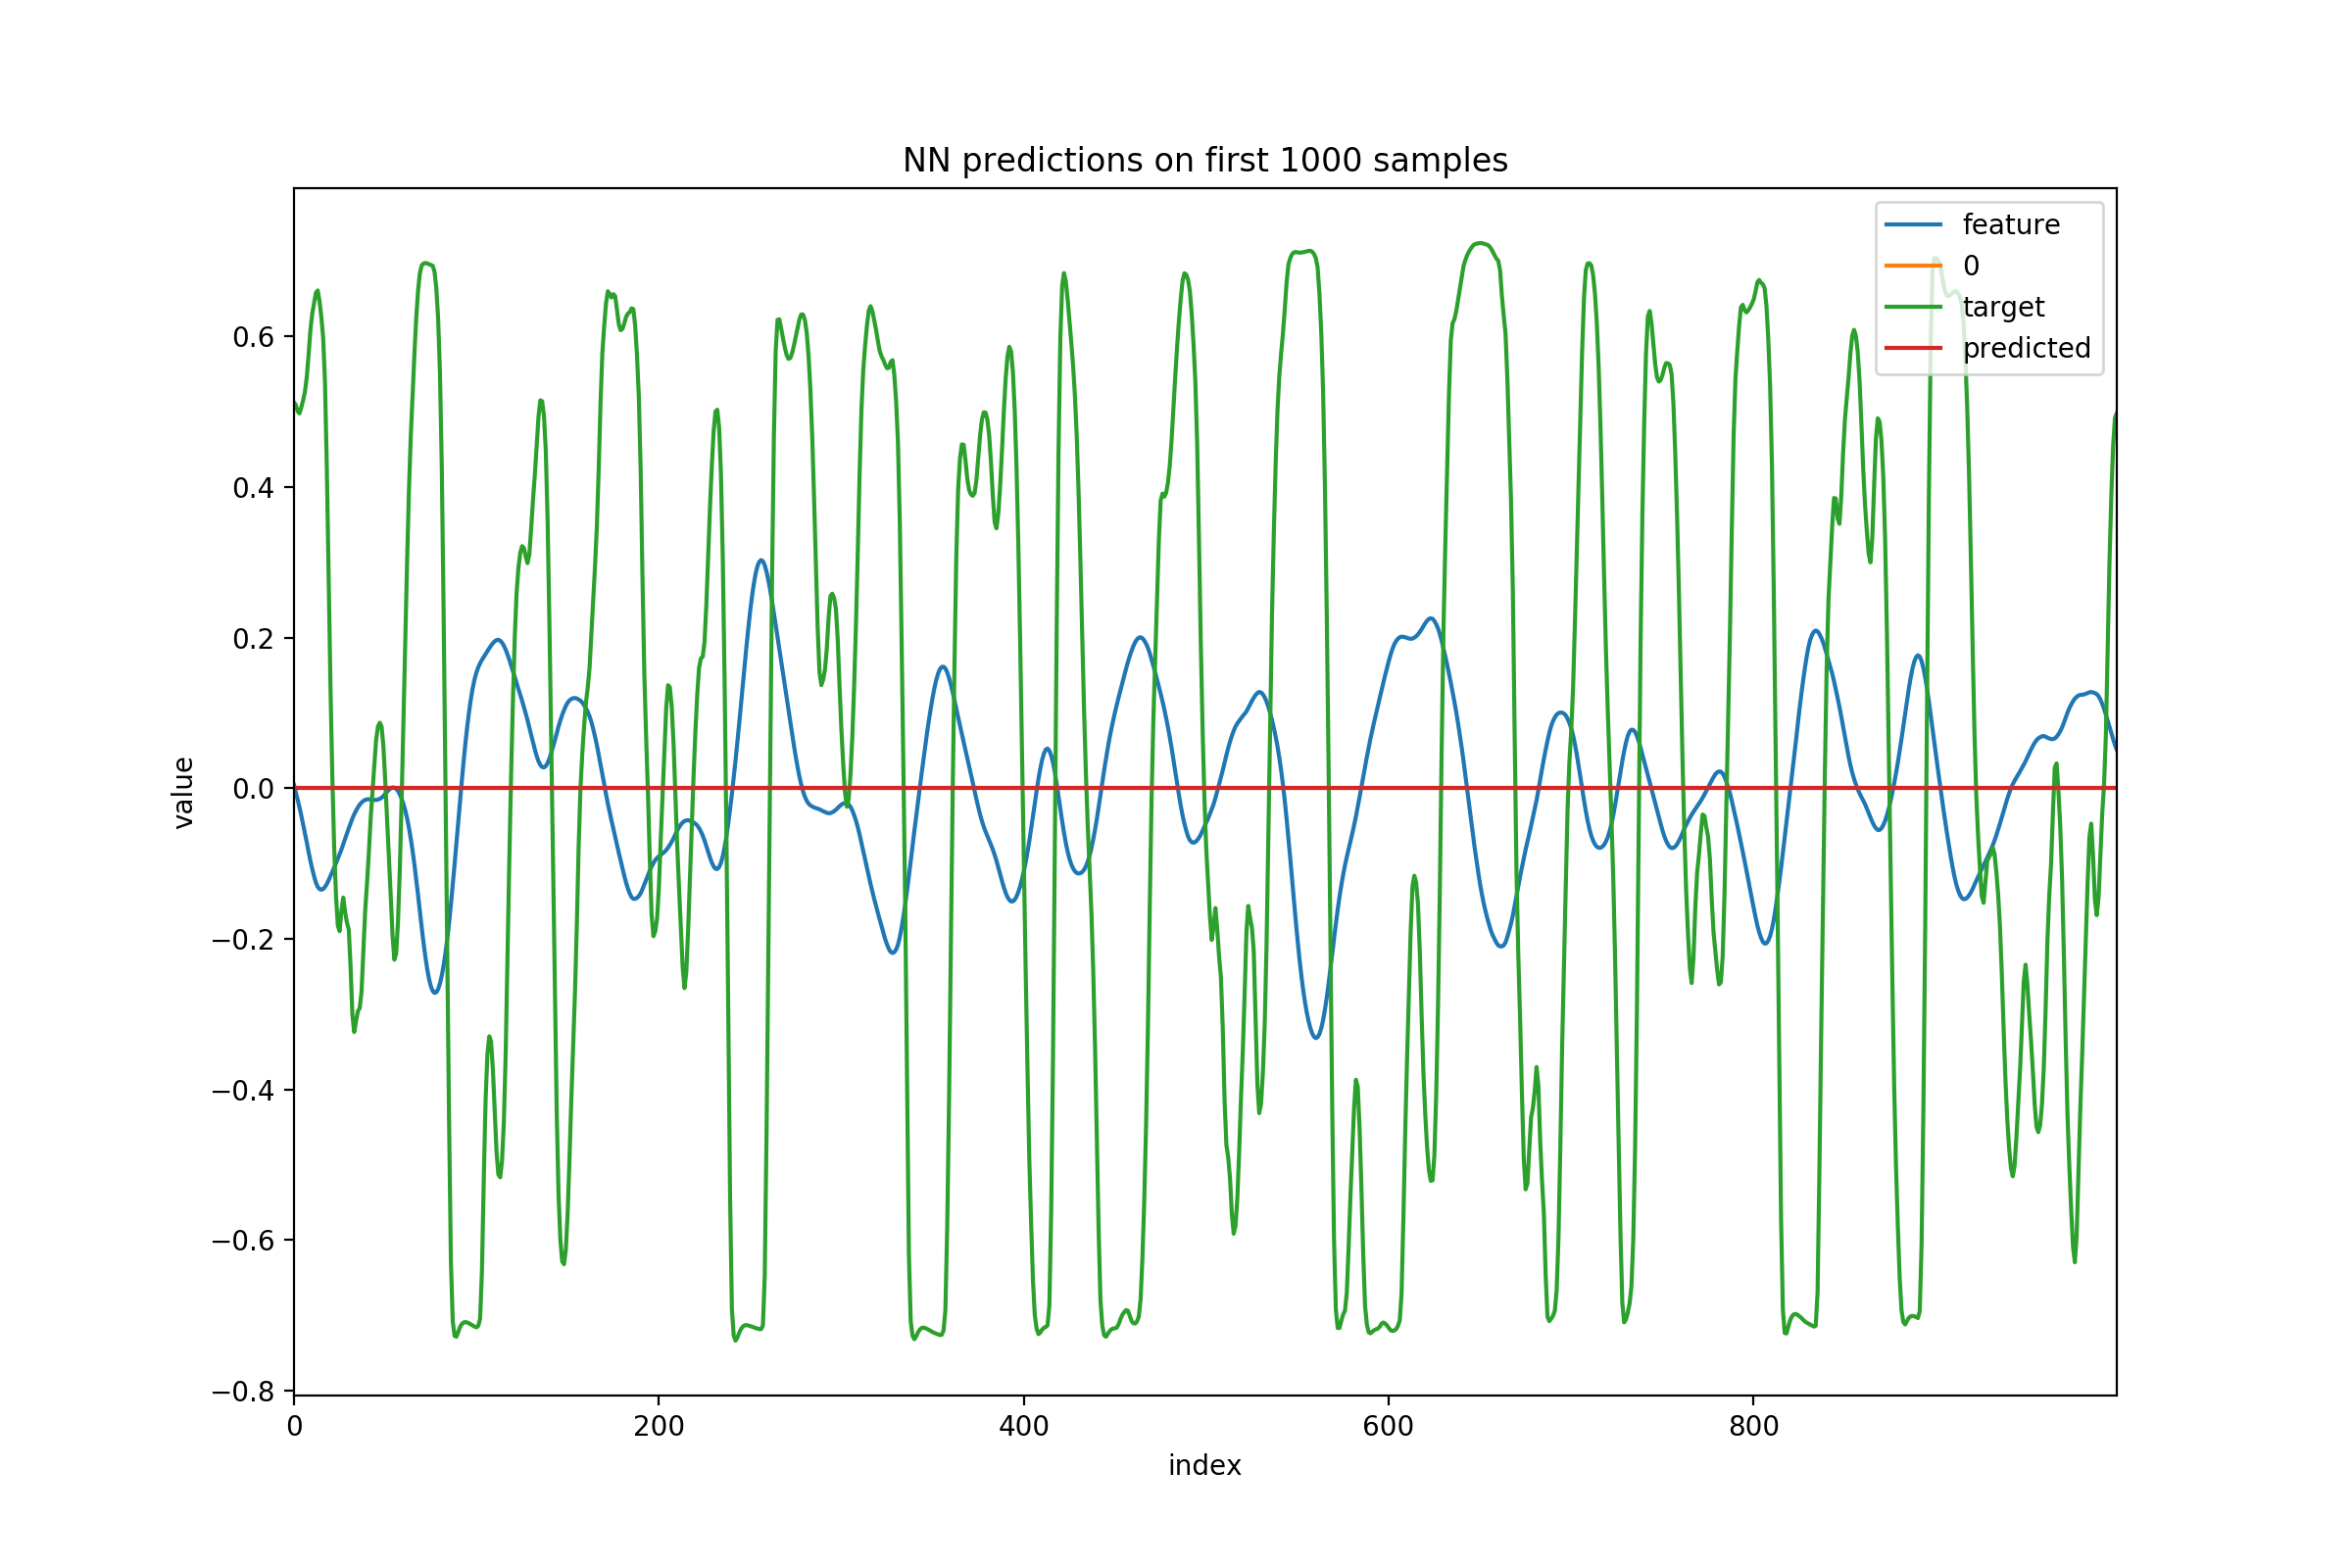

Epoch 1/100


UnknownError: 2 root error(s) found.
  (0) Unknown: Fail to find the dnn implementation.
	 [[{{node cu_dnngru_4/CudnnRNN}}]]
	 [[loss_2/mul/_163]]
  (1) Unknown: Fail to find the dnn implementation.
	 [[{{node cu_dnngru_4/CudnnRNN}}]]
0 successful operations.
0 derived errors ignored.

In [30]:
%%time
%matplotlib notebook

best_params = {
#     'lr': 0.0005,
#     'lr': 0.01,
    'lr': 0.003,
    'n_samples': 399000,
    'n_units': 1,
#     'n_units': 40,
    'batch_size': 1000,
#     'epochs': 100,
    'epochs': 100,
    'optimizer': keras.optimizers.Adam,
}


# model = load_model('saved_models/02_peak_comp_60_samples_180_params.h5')
model = create_model(best_params)

history, model = train_model(
    model,
    X_tr_s[:best_params['n_samples']],
    y_tr_s[:best_params['n_samples']],
    best_params,
    verbose_fit=1,
    preview_n_start=14000,
    preview_n_end=15000,
)

globals().update(locals())

In [199]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    print(weights)
    print('='*20)

[]
[array([[-1.39819896e+00,  2.58286241e-02,  1.82570145e-01,
        -6.32471561e-01, -1.79288968e-01,  2.07998663e-01,
         1.32404849e-01,  1.32346988e+00, -4.37388510e-01,
         2.24737692e+00,  2.16688848e+00,  8.79426524e-02,
         5.20192194e+00, -2.34141611e-02, -1.85434833e-01,
        -4.05700731e+00, -3.55899446e-02,  5.72855137e-02],
       [ 2.36740398e+00, -6.88859671e-02, -2.37808805e-02,
         1.68795511e-01, -1.78383640e-03, -6.01844192e-02,
        -1.87389195e+00,  1.06871951e+00,  1.74216747e-01,
         7.70081711e+00, -3.93146165e-02,  1.31515071e-01,
        -9.78203267e-02,  1.12601906e-01,  1.41677586e-02,
        -2.88531494e+00, -1.63944922e-02,  1.22071460e-01],
       [-8.68249774e-01, -1.99198015e-02,  3.87635380e-02,
        -5.05025244e+00, -1.37433156e-01,  1.21140620e-02,
         2.63157511e+00,  1.08991432e+00, -2.77272671e-01,
         1.36928022e-01,  2.29082629e-01,  1.89845967e+00,
         2.80937719e+00,  1.66310892e-02,  2.78939

In [200]:
model.layers[2].get_weights()[0]

array([[ 0.71196204],
       [-0.02221588],
       [ 0.08630091],
       [ 1.0685208 ],
       [ 0.850598  ],
       [ 0.2390236 ]], dtype=float32)

In [201]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (1000, 64, 3)             0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (1000, 6)                 198       
_________________________________________________________________
dense_3 (Dense)              (1000, 1)                 7         
Total params: 205
Trainable params: 205
Non-trainable params: 0
_________________________________________________________________


In [202]:
model.save('saved_models/01_gru_6_units_01.h5')

In [203]:
score = model.evaluate(X_te_s[:7000], y_te_s[:7000], verbose=0, batch_size=best_params['batch_size'])
score

0.1477895730308124

In [50]:
0.1430590125421683
0.040487171824161824

0.040487171824161824

In [204]:
%matplotlib inline

from matplotlib import pyplot as plt

# Plot training & validation loss values
plt.plot(normalize(np.array(history.history['loss'])))
# plt.plot(normalize(np.array(history.history['val_loss'])))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [205]:
len(X_te_s)

7870

In [58]:
pred = predict(model, X_te_s[:2*44000], batch_size=best_params['batch_size'])
ipd.Audio(pred, rate=44000)

In [59]:
print(X_tr_s[0][-1])

[ 0. -5.  0.]


In [75]:
from keras import backend as K

def divide_chunks(l, n): 
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 
        
def get_activations_batch(model, n_layer, X_batch):
    get_activations = K.function([model.layers[0].input], [model.layers[n_layer].output])
    activations = get_activations([X_batch, 0])[0]
    return activations

def get_activations(model, n_layer, X, batch_size):
    chunks = divide_chunks(X, batch_size)
    return np.concatenate([get_activations_batch(model, n_layer, X_batch) for X_batch in chunks])

In [79]:
get_activations(model, 1, X_tr_s[:2000], best_params['batch_size'])[:3]

array([[ 1.        ,  0.7350165 ,  0.99999666,  0.993649  , -0.99999994,
         0.23880738,  0.953165  ,  0.15217732,  0.99743134,  1.        ,
         0.99999785, -0.03889839, -0.99999785,  0.82558966, -0.99716634,
        -0.68713343, -0.23584732,  0.4237997 , -0.9999999 , -0.999841  ,
        -0.9576221 , -0.10611475, -0.13686267, -0.99912405],
       [ 1.        ,  0.735579  ,  0.9999966 ,  0.99366   , -0.99999994,
         0.23837912,  0.95343316,  0.15351263,  0.99743134,  1.        ,
         0.99999785, -0.03890467, -0.99999785,  0.82557327, -0.9971662 ,
        -0.68684864, -0.23518775,  0.41855776, -0.9999999 , -0.99984413,
        -0.9576741 , -0.10585959, -0.13685378, -0.99912405],
       [ 1.        ,  0.73611784,  0.99999654,  0.9936677 , -0.99999994,
         0.23788646,  0.953497  ,  0.15426376,  0.9974319 ,  1.        ,
         0.99999785, -0.03897721, -0.99999785,  0.8258032 , -0.99716586,
        -0.68680143, -0.23472807,  0.41283783, -0.9999999 , -0.9998479 ,
  

Text(0, 0.5, 'value')

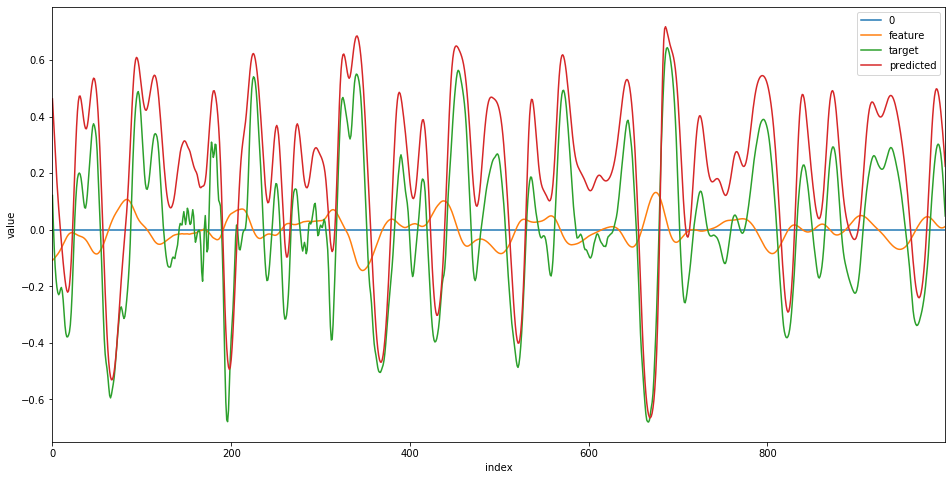

In [270]:
%matplotlib inline
from scipy.signal import savgol_filter

(fig, ax) = plt.subplots(figsize=(16, 8))

I = 1000
MAGIC_OFFSET = 180000
OFFSET = int(MAGIC_OFFSET)

X_to_test = X_tr_s
y_to_test = y_tr_s

zeros = pd.Series(np.zeros(I))
zeros.plot.line(ax=ax, label='0')

feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_to_test[:(I + OFFSET)]))))[OFFSET:])

feat.plot.line(ax=ax, label='feature')

targ = pd.Series(y_to_test[OFFSET:(I + OFFSET)])

pred = pd.Series(predict(model, X_to_test[:(I + OFFSET)], batch_size=best_params['batch_size'])[OFFSET:])
# pred = (pred * 3.2) + 0.001
pred = pred + 0.001

act = pd.Series([ row[1] for row in get_activations( model, 1, X_to_test[OFFSET:(I + OFFSET)], best_params['batch_size'])] )

IMPORTANT_GRUS = []

# act.plot.line(ax=ax, label='GRU layer activation')

targ.plot.line(ax=ax, label='target')

pred.plot.line(ax=ax, label='predicted')
# pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

# pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_te_f[:I]))))).plot.line(ax=ax, label='feature')

ax.legend(loc="upper right")
ax.set_xlabel('index')
ax.set_ylabel('value')

In [263]:
weights = model.layers[1].get_weights()
(W, U, b) = weights
W.shape, U.shape, b.shape

((3, 18), (6, 18), (36,))

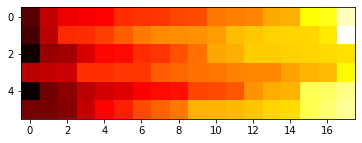

In [268]:
plt.imshow(np.sort(U, axis=1), cmap='hot', interpolation='nearest')

In [196]:
U_c = np.array([])

# we have 3 features

units = best_params['n_units']

W_0_h = W[0, :units]
W_0_r = W[0, units: units * 2]
W_0_z = W[0, units * 2: units * 3]

W_1_h = W[1, :units]
W_1_r = W[1, units: units * 2]
W_1_z = W[1, units * 2: units * 3]

W_2_h = W[2, :units]
W_2_r = W[2, units: units * 2]
W_2_z = W[2, units * 2: units * 3]

U_h = U[:, :units]
U_r = U[:, units: units * 2]
U_z = U[:, units * 2: units * 3]

b_1 = b[:units]
b_2 = b[units: units * 2]
b_3 = b[units * 2: units * 3]
b_4 = b[units * 3: units * 4]
b_5 = b[units * 4: units * 5]
b_6 = b[units * 5:]

U_h.shape

(24, 24)

In [244]:
pred_unit = pd.Series([ row[1] for row in get_activations( model, 1, X_tr_s[:230000], best_params['batch_size'])] )
pred_unit[:10]

0   -0.015799
1   -0.014937
2   -0.013678
3   -0.012008
4   -0.009968
5   -0.007628
6   -0.005082
7   -0.002414
8    0.000302
9    0.003055
dtype: float64

In [245]:
ipd.Audio(pred_unit, rate=44000)

In [195]:
N = 5

W_su = np.array([
    np.array([ W_0_h[N], W_0_r[N], W_0_z[N] ]),
    np.array([ W_1_h[N], W_1_r[N], W_1_z[N] ]),
    np.array([ W_2_h[N], W_2_r[N], W_2_z[N] ])
])

U_su = np.array([
    np.array([
        U_h[N],
        U_r[N],
        U_z[N],
    ])
])

W_su, U_su

(array([[-0.0022899893,  0.43562603  ,  0.028196046 ],
        [-0.4824497   , -0.05763771  ,  0.2697497   ],
        [ 0.04989334  ,  0.3810869   ,  0.039342176 ]], dtype=float32),
 array([[[-3.28866951e-02, -1.02324295e+00,  1.74627975e-01,
          -1.16138242e-01,  1.10327318e-01,  8.43107641e-01,
          -9.35797155e-01,  3.73737454e-01,  1.41992664e-03,
           1.65796295e-01,  7.76039004e-01,  6.43501699e-01,
          -5.35436384e-02, -4.69782352e-01,  6.31801635e-02,
           1.45995095e-01,  3.51827174e-01, -1.45192659e+00,
          -1.70130923e-01,  2.93677241e-01, -9.04179037e-01,
           5.07917464e-01, -4.41755801e-01,  1.66603476e-02],
         [ 1.28369465e-01,  1.61231029e+00,  1.47629336e-01,
          -2.88780802e-03,  6.84055267e-03, -2.18628216e+00,
           2.54989767e+00, -5.75977683e-01,  1.77933022e-01,
          -5.33041321e-02,  3.97446975e-02,  8.55978489e-01,
          -2.17247561e-01,  3.27902317e-01, -8.43632035e-03,
           1.04471199e-0

In [172]:
layer = model.layers[1]

In [170]:
W_1.shape

(24, 24)

In [57]:
matplotlib inline

def plot_params(l, m):
    (fig, ax) = plt.subplots(figsize=(16, 8))

    I = 1000
    MAGIC_OFFSET = 180000
    OFFSET = int(MAGIC_OFFSET)

    X_source = np.array(list(map(lambda x: [x, l, m], source_df[OFFSET:(I + OFFSET + N_WINDOW_POINTS + 1)] / MAX_VALUE)))
    (X, _) = make_windows(X_source, [0] * (I + N_WINDOW_POINTS + 1), N_WINDOW_POINTS)
    X_to_test = X
    

    feat = source_df[OFFSET:(I + OFFSET)].reset_index()['L'] / MAX_VALUE
    
    feat.plot.line(ax=ax, label='feature')

#     targ = pd.Series(y_to_test[OFFSET:(I + OFFSET)])
    
    pred = pd.Series(predict(model, X_to_test, batch_size=best_params['batch_size']))
    # pred = (pred * 3.2) + 0.001
    pred = pred + 0.001
    
    zeros = pd.Series(np.zeros(I))
    zeros.plot.line(ax=ax, label='0')

#     targ.plot.line(ax=ax, label='target')

    pred.plot.line(ax=ax, label='predicted')
    
    ax.legend(loc="upper right")
    ax.set_xlabel('index')
    ax.set_ylabel('value')

In [156]:
from ipywidgets import interact

interact(plot_params, l=(0, 10), m=(0, 10))

interactive(children=(IntSlider(value=5, description='l', max=10), IntSlider(value=5, description='m', max=10)…

<function __main__.plot_params(l, m)>


## Time to evaluate performance

In [254]:
from math import floor

train_pred = predict(model, X_tr_s[:floor(len(X_tr_s) / best_params['batch_size']) * best_params['batch_size']], batch_size=best_params['batch_size'])
ipd.Audio(train_pred, rate=44000)

In [114]:
# X_to_repeat = X_tr_s[:int(44000 * 2.8)]
# X_to_pred = np.concatenate([X_to_repeat, X_to_repeat, X_to_repeat])
# len(X_to_pred) / 44000, X_to_pred[0][:4], X_to_pred[1][:4]

In [61]:
def mapper(a):
    i = a[0]
    row = a[1]
    
    t = i / len(X_to_pred)
    gain = 1.0 * (1 - t) + 6.4 * t
    
    return np.array(list(map(lambda x: [x[0], gain], row)))

# X_to_pred = np.array(list(map(mapper, enumerate(X_to_pred))))

# X_to_pred[0][:5], X_to_pred[1][:5], X_to_pred[-2][:5], X_to_pred[-1][:5]

In [67]:
X_to_pred = X_tr_s[:(X_tr_s.shape[0] // best_params['batch_size']) * best_params['batch_size']]

In [68]:
predictions = predict(model, X_to_pred, batch_size=best_params['batch_size'], verbose=1)
len(predictions), predictions[:10], np.max(predictions), np.min(predictions)

263000/263000 [==============================] - 1s 3us/step


(263000,
 array([-0.05937488, -0.0590545 , -0.05882681, -0.05877836, -0.05880947,
        -0.05874747, -0.05854729, -0.05837908, -0.0582295 , -0.05822694],
       dtype=float32),
 1.0069656,
 -1.3094412)

In [69]:
np.min(y_te_s)

-0.74059266

In [70]:
predictions_n = np.clip((predictions / 1.2) * 0.8, -1.0, 1.0) * MAX_VALUE
len(predictions_n), predictions_n[:10], np.max(predictions_n), np.min(predictions_n)

(263000, array([-1297.0243, -1290.0258, -1285.052 , -1283.9937, -1284.6731,
        -1283.3188, -1278.9459, -1275.2715, -1272.004 , -1271.948 ],
       dtype=float32), 21996.826, -28604.305)

In [71]:
wavfile.write('output/pred_out_gr_jump_head_gain_2_params_v3.wav', source_fs, predictions)

In [128]:
len(predictions) / 44000

1.9772727272727273